In [1]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [5]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        if epoch == 25 and flag == 0:
          for op_params in optimizer.param_groups:
            op_params['lr'] = 0.001
          flag = 1
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            print(images.shape, labels.shape)

            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            if (i+1) % 1000 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            running_loss_val = 0.0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss_val = criterion(outputs, labels)
                running_loss_val += loss_val.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss_val)
    return val_error,val_loss_values,train_error,train_loss_values


Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [6]:
model = allcnn_t().to(device)
epoch_1 = 40 
epoch_2 = 40 
epoch_3 = 20 
alpha_1 = 0.1
alpha_2 = 0.01 
alpha_3 = 0.001 

criterion = nn.CrossEntropyLoss()

Num parameters:  1667166


(a)

In [7]:
#Learning rate of 0.1 for the first 40 epochs
optimizer1 = optim.SGD(model.parameters(), lr=alpha_1, momentum=0.9, weight_decay=0.0001)
val_err, val_loss, train_err, train_loss = train(model, optimizer1, criterion, trainloader, testloader, epoch_1, 'cnn', False)

torch.Size([16, 3, 32, 32]) torch.Size([16])


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), "/content/allcnn_v0")
model2 = model

In [ ]:
# 0.01 for the next 40 epochs
optimizer2 = optim.SGD(model2.parameters(), lr=alpha_2, momentum=0.9, weight_decay=0.0001)
val_err2, val_loss2, train_err2, train_loss2 = train(model2, optimizer2, criterion, trainloader, testloader, epoch_2, 'cnn', False)

Epoch [1/40], Step [1000/3125], Loss: 0.0306
Epoch [1/40], Step [2000/3125], Loss: 0.0766
Epoch [1/40], Step [3000/3125], Loss: 0.0262
Accuracy of the network on the test images: 87.85 %
Epoch [2/40], Step [1000/3125], Loss: 0.0213
Epoch [2/40], Step [2000/3125], Loss: 0.0109
Epoch [2/40], Step [3000/3125], Loss: 0.0076
Accuracy of the network on the test images: 88.32 %
Epoch [3/40], Step [1000/3125], Loss: 0.0280
Epoch [3/40], Step [2000/3125], Loss: 0.0300
Epoch [3/40], Step [3000/3125], Loss: 0.0144
Accuracy of the network on the test images: 88.17 %
Epoch [4/40], Step [1000/3125], Loss: 0.0071
Epoch [4/40], Step [2000/3125], Loss: 0.0027
Epoch [4/40], Step [3000/3125], Loss: 0.0119
Accuracy of the network on the test images: 88.06 %
Epoch [5/40], Step [1000/3125], Loss: 0.0245
Epoch [5/40], Step [2000/3125], Loss: 0.0102
Epoch [5/40], Step [3000/3125], Loss: 0.0009
Accuracy of the network on the test images: 88.34 %
Epoch [6/40], Step [1000/3125], Loss: 0.0032
Epoch [6/40], Step [

In [ ]:
torch.save(model2.state_dict(), "/content/allcnn_v1")
model3 = model2

In [ ]:
# 0.001 for the final 20 epochs
optimizer3 = optim.SGD(model3.parameters(), lr=alpha_3, momentum=0.9, weight_decay=0.0001)
val_err3, val_loss3, train_err3, train_loss3 = train(model3, optimizer3, criterion, trainloader, testloader, epoch_3, 'cnn', False)

Epoch [1/20], Step [1000/3125], Loss: 0.0053
Epoch [1/20], Step [2000/3125], Loss: 0.0024
Epoch [1/20], Step [3000/3125], Loss: 0.0039
Accuracy of the network on the test images: 87.56 %
Epoch [2/20], Step [1000/3125], Loss: 0.0012
Epoch [2/20], Step [2000/3125], Loss: 0.0051
Epoch [2/20], Step [3000/3125], Loss: 0.0039
Accuracy of the network on the test images: 87.41 %
Epoch [3/20], Step [1000/3125], Loss: 0.0005
Epoch [3/20], Step [2000/3125], Loss: 0.0032
Epoch [3/20], Step [3000/3125], Loss: 0.0028
Accuracy of the network on the test images: 87.51 %
Epoch [4/20], Step [1000/3125], Loss: 0.0025
Epoch [4/20], Step [2000/3125], Loss: 0.0050
Epoch [4/20], Step [3000/3125], Loss: 0.0054
Accuracy of the network on the test images: 87.51 %
Epoch [5/20], Step [1000/3125], Loss: 0.0042
Epoch [5/20], Step [2000/3125], Loss: 0.0017
Epoch [5/20], Step [3000/3125], Loss: 0.0019
Accuracy of the network on the test images: 87.6 %
Epoch [6/20], Step [1000/3125], Loss: 0.0034
Epoch [6/20], Step [2

In [ ]:
# save
torch.save(model3.state_dict(), "/content/allcnn_v2")

In [ ]:
val_err += val_err2
val_err += val_err2
train_err += train_err2
train_err += train_err3
val_loss += val_loss2
val_loss += val_loss3
train_loss += train_loss2
train_loss += train_loss3

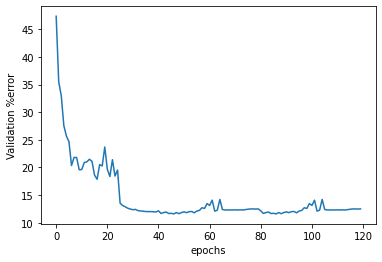

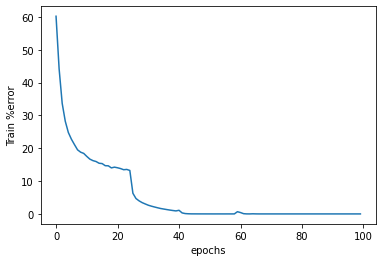

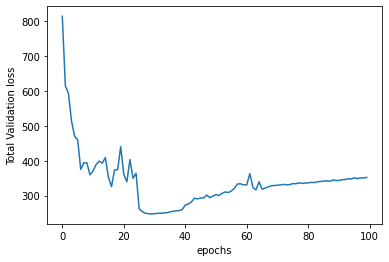

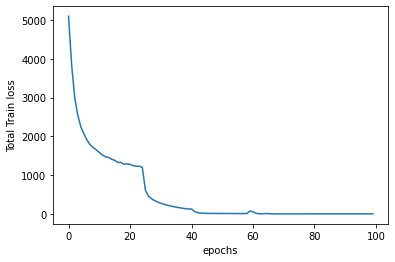

In [ ]:
plt.plot(val_err)
plt.xlabel('epochs')
plt.ylabel('Validation %error')
plt.show()

plt.plot(train_err)
plt.xlabel('epochs')
plt.ylabel('Train %error')
plt.show()

plt.plot(val_loss)
plt.xlabel('epochs')
plt.ylabel('Total Validation loss')
plt.show()

plt.plot(train_loss)
plt.xlabel('epochs')
plt.ylabel('Total Train loss')
plt.show()

(b)

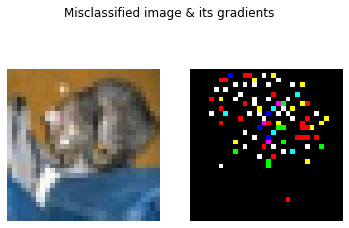

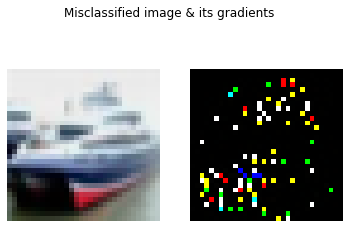

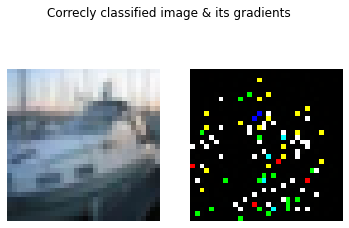

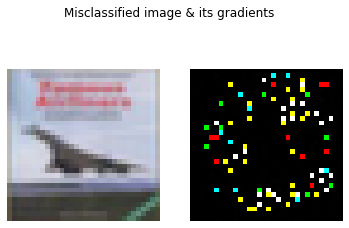

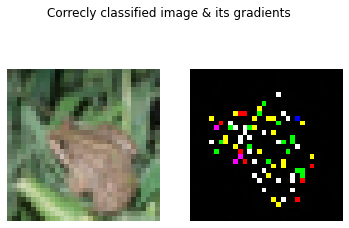

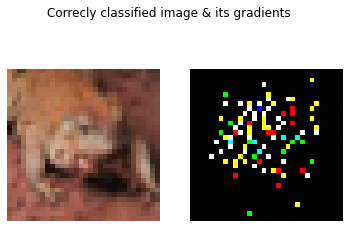

In [ ]:
import numpy as np
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
model3.eval()
corr = 0
mis = 0
num = 3
for i, (images, labels) in enumerate(testloader):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model3(images)
    loss = criterion(outputs, labels)
    optimizer3.zero_grad()
    loss.backward()

    _, predicted = torch.max(outputs.data, 1)
    if corr == num:
        break

    if ((predicted != labels).sum().item() == 0) and (mis < num):
        dx = images.grad.data.clone()
        grad = dx.to('cpu')
        grad_i = (grad.detach().numpy())[0]
        grad_i = grad_i.transpose((1,2,0))
        grad_i = (grad_i - np.mean(grad_i))/ np.std(grad_i) + 0.5

        fig, axs = plt.subplots(1, 2)
        fig.suptitle('Misclassified image & its gradients')
        axs[0].imshow(testloader.dataset.data[i].astype('uint8'))
        axs[0].axis('off')
        axs[1].imshow(grad_i.astype('uint8'))
        axs[1].axis('off')
        mis += 1
    else:
        dx = images.grad.data.clone()
        grad = dx.to('cpu')
        grad_i = (grad.detach().numpy())[0]
        grad_i = grad_i.transpose((1,2,0))
        grad_i = (grad_i - np.mean(grad_i))/ np.std(grad_i) + 0.5

        fig, axs = plt.subplots(1, 2)
        fig.suptitle('Correcly classified image & its gradients')
        axs[0].imshow(testloader.dataset.data[i].astype('uint8'))
        axs[0].axis('off')
        axs[1].imshow(grad_i.astype('uint8'))
        axs[1].axis('off')
        corr += 1

Step: 0 Loss: 75.46561803080584
Step: 1 Loss: 1267.083490693531
Step: 2 Loss: 2999.7622647415847
Step: 3 Loss: 4449.290193557739
Step: 4 Loss: 5666.468829154968


Text(0, 0.5, 'Loss')

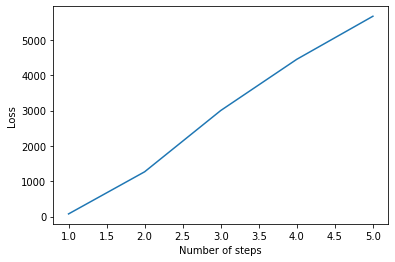

In [ ]:
from torch.utils.data import SubsetRandomSampler
sampler = SubsetRandomSampler(list(range(100)))

testloader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=False, sampler=sampler)

epsilon = 8
images = []
labels = []
for i, (image, label) in enumerate(testloader):
    images.append(image)
    labels.append(label)

losses = []
for k in range(5):
  # loss 
  l = 0
  for i in range(100):
    image = images[i].to(device) 
    label = labels[i].to(device)
    image = nn.Parameter(image)
    image.requires_grad = True   
    output = model3(image)
    loss = criterion(output, label)
    optimizer3.zero_grad()
    loss.backward()
    # record loss 
    l += loss.item()
    dx = image.grad.data.clone()
    dx = torch.sign(dx)
    images[i] = image + (epsilon*1.0/255)*dx
  losses.append(l)
  print("Step: {} Loss: {}".format(k,l))

plt.plot(np.arange(5)+1, losses)
plt.xlabel('Number of steps')
plt.ylabel('Loss')

(c)

In [ ]:
loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=False)

epsilon = 8
images = []
labels = []
for i, (image, label) in enumerate(loader):
    images.append(image)
    labels.append(label)

model3.eval()
with torch.no_grad():
  corr_num = 0
  total = 0
  for i in range(len(images)):
      image = images[i].to(device) 
      label = labels[i].to(device)
      output = model3(image)
      _, pred = torch.max(output.data, 1)
      total += label.size(0)
      corr_num += (pred == label).sum().item()

print("Accuracy before the 1-step attack: {}%".format(100*corr_num/total))


Accuracy before the 1-step attack: 87.38%


In [ ]:
for i in range(len(images)):
    image = images[i].to(device) 
    label = labels[i].to(device)
    image = nn.Parameter(image)
    image.requires_grad = True   
    output = model3(image)
    loss = criterion(output, label)
    optimizer3.zero_grad()
    loss.backward()
    dx = image.grad.data.clone()
    dx = torch.sign(dx)
    images[i] = image + (epsilon*1.0/255)*dx

model3.eval()
with torch.no_grad():
  corr_num = 0
  total = 0
  for i in range(len(images)):
      image = images[i].to(device) 
      label = labels[i].to(device)
      output = model3(image)
      _, pred = torch.max(output.data, 1)
      total += label.size(0)
      corr_num += (pred == label).sum().item()

print("Accuracy after the 1-step attack: {}%".format(100*corr_num/total))

Accuracy after the 1-step attack: 13.67%
